https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

Download data:
    
`wget https://download.pytorch.org/tutorial/data.zip`

In [1]:
from io import open
import glob
import random
import time
import math
import unicodedata
import string

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import torch.nn as nn

torch.manual_seed(1)

In [2]:
def findFiles(path):
    return glob.glob(path)

name_files = findFiles('../data/names/*.txt')
print(name_files)

['../data/names/Italian.txt', '../data/names/Dutch.txt', '../data/names/German.txt', '../data/names/Japanese.txt', '../data/names/Greek.txt', '../data/names/Scottish.txt', '../data/names/Czech.txt', '../data/names/Chinese.txt', '../data/names/Irish.txt', '../data/names/French.txt', '../data/names/English.txt', '../data/names/Korean.txt', '../data/names/Polish.txt', '../data/names/Spanish.txt', '../data/names/Vietnamese.txt', '../data/names/Portuguese.txt', '../data/names/Russian.txt', '../data/names/Arabic.txt']


In [3]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
print(all_letters)
print(n_letters)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
57


In [4]:
# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [5]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in name_files:
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [6]:
print(all_categories)

['Italian', 'Dutch', 'German', 'Japanese', 'Greek', 'Scottish', 'Czech', 'Chinese', 'Irish', 'French', 'English', 'Korean', 'Polish', 'Spanish', 'Vietnamese', 'Portuguese', 'Russian', 'Arabic']


In [7]:
for k, v in category_lines.items():
    print('{0:10s}: {1}'.format(k, v[:5]))

Italian   : ['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']
Dutch     : ['Aalsburg', 'Aalst', 'Aarle', 'Achteren', 'Achthoven']
German    : ['Abbing', 'Abel', 'Abeln', 'Abt', 'Achilles']
Japanese  : ['Abe', 'Abukara', 'Adachi', 'Aida', 'Aihara']
Greek     : ['Adamidis', 'Adamou', 'Agelakos', 'Akrivopoulos', 'Alexandropoulos']
Scottish  : ['Smith', 'Brown', 'Wilson', 'Campbell', 'Stewart']
Czech     : ['Abl', 'Adsit', 'Ajdrna', 'Alt', 'Antonowitsch']
Chinese   : ['Ang', 'AuYong', 'Bai', 'Ban', 'Bao']
Irish     : ['Adam', 'Ahearn', 'Aodh', 'Aodha', 'Aonghuis']
French    : ['Abel', 'Abraham', 'Adam', 'Albert', 'Allard']
English   : ['Abbas', 'Abbey', 'Abbott', 'Abdi', 'Abel']
Korean    : ['Ahn', 'Baik', 'Bang', 'Byon', 'Cha']
Polish    : ['Adamczak', 'Adamczyk', 'Andrysiak', 'Auttenberg', 'Bartosz']
Spanish   : ['Abana', 'Abano', 'Abarca', 'Abaroa', 'Abascal']
Vietnamese: ['Nguyen', 'Tron', 'Le', 'Pham', 'Huynh']
Portuguese: ['Abreu', 'Albuquerque', 'Almeida', 'Alves

In [8]:
n_categories

18

## Turning Names into Tensors

In [9]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
torch.Size([5, 1, 57])


## Creating the Network

<img src="https://i.imgur.com/Z2xbySO.png" alt/>

In [10]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [11]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [12]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
print(output)
print(next_hidden)

tensor([[-2.8739, -2.9028, -2.8908, -2.8810, -2.9101, -2.8985, -2.9106,
         -2.9278, -2.9383, -2.8299, -2.8164, -2.7802, -3.0030, -2.8686,
         -2.8727, -2.9259, -2.9581, -2.8613]])
tensor([[ 0.0366,  0.0225,  0.0708, -0.0385,  0.0178, -0.0594,  0.1098,
          0.0313, -0.0124, -0.0531,  0.1124, -0.0163,  0.0029, -0.0306,
         -0.0145, -0.0395, -0.0657,  0.0420,  0.0152,  0.0811,  0.0221,
          0.1079,  0.0078,  0.0289,  0.0194,  0.0564, -0.0383, -0.0354,
         -0.0176,  0.0266,  0.0718, -0.0345, -0.1332,  0.0068,  0.0023,
         -0.0116, -0.0452, -0.0823,  0.1196,  0.0225,  0.1072,  0.0365,
         -0.0628,  0.0230,  0.0613,  0.0823,  0.0255,  0.0628,  0.0675,
          0.0179,  0.0185,  0.0136,  0.0169,  0.0167,  0.0931,  0.0104,
          0.0371, -0.0294,  0.0551,  0.0226, -0.0818,  0.1440,  0.0680,
          0.0151,  0.0009, -0.0173, -0.0005,  0.1138,  0.0037, -0.1238,
         -0.0228,  0.1202, -0.0505, -0.0571,  0.0612, -0.0445, -0.0035,
         -0.0046,

In [13]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)
print(next_hidden)

tensor([[-2.8739, -2.9028, -2.8908, -2.8810, -2.9101, -2.8985, -2.9106,
         -2.9278, -2.9383, -2.8299, -2.8164, -2.7802, -3.0030, -2.8686,
         -2.8727, -2.9259, -2.9581, -2.8613]])
tensor([[ 0.0366,  0.0225,  0.0708, -0.0385,  0.0178, -0.0594,  0.1098,
          0.0313, -0.0124, -0.0531,  0.1124, -0.0163,  0.0029, -0.0306,
         -0.0145, -0.0395, -0.0657,  0.0420,  0.0152,  0.0811,  0.0221,
          0.1079,  0.0078,  0.0289,  0.0194,  0.0564, -0.0383, -0.0354,
         -0.0176,  0.0266,  0.0718, -0.0345, -0.1332,  0.0068,  0.0023,
         -0.0116, -0.0452, -0.0823,  0.1196,  0.0225,  0.1072,  0.0365,
         -0.0628,  0.0230,  0.0613,  0.0823,  0.0255,  0.0628,  0.0675,
          0.0179,  0.0185,  0.0136,  0.0169,  0.0167,  0.0931,  0.0104,
          0.0371, -0.0294,  0.0551,  0.0226, -0.0818,  0.1440,  0.0680,
          0.0151,  0.0009, -0.0173, -0.0005,  0.1138,  0.0037, -0.1238,
         -0.0228,  0.1202, -0.0505, -0.0571,  0.0612, -0.0445, -0.0035,
         -0.0046,

## Training

### Preparing for Training

In [14]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Korean', 11)


In [15]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

In [16]:
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Spanish / line = Mingo
category = Greek / line = Sardelis
category = German / line = Tolkien
category = Russian / line = Kaleshin
category = Portuguese / line = Rodrigues
category = Irish / line = Ceallach
category = Greek / line = Adamou
category = German / line = Adenauer
category = Portuguese / line = Matos
category = German / line = Forst


### Training the Network

In [17]:
criterion = nn.NLLLoss()

In [18]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [19]:
%%time

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 23s) 2.2523 Switzer / German ✓
10000 10% (0m 42s) 2.9713 Tunneson / Scottish ✗ (Dutch)
15000 15% (1m 10s) 1.5025 Natsume / Japanese ✓
20000 20% (1m 35s) 1.3706 Jin / Korean ✗ (Chinese)
25000 25% (1m 55s) 0.7361 Teng / Chinese ✓
30000 30% (2m 15s) 1.6838 Mohan / Arabic ✗ (Irish)
35000 35% (2m 38s) 2.1606 Alam / Irish ✗ (English)
40000 40% (2m 59s) 0.6290 Dubhain / Irish ✓
45000 45% (3m 22s) 1.0806 Sobol / Polish ✓
50000 50% (3m 48s) 0.7361 Ganim / Arabic ✓
55000 55% (4m 12s) 1.2462 Schoorel / Dutch ✓
60000 60% (4m 33s) 0.1987 Gan / Chinese ✓
65000 65% (4m 54s) 0.9761 Ho / Korean ✗ (Vietnamese)
70000 70% (5m 20s) 0.5796 Moon / Korean ✓
75000 75% (5m 41s) 3.0433 Lanham / Arabic ✗ (English)
80000 80% (6m 0s) 1.2879 Yeo / Chinese ✗ (Korean)
85000 85% (6m 25s) 1.8016 Opp / German ✗ (Czech)
90000 90% (6m 48s) 2.0614 Kore / Scottish ✗ (English)
95000 95% (7m 18s) 0.1419 Chukhonkin / Russian ✓
100000 100% (7m 44s) 0.4395 Shaw / Chinese ✓
CPU times: user 17min 41s, sys: 32min 57s, to

### Plotting the Results

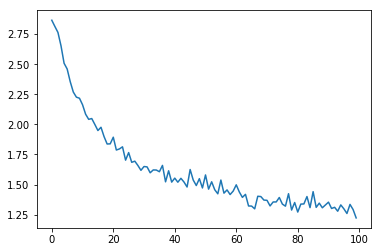

In [20]:
plt.figure()
plt.plot(all_losses)

### Evaluating the Results

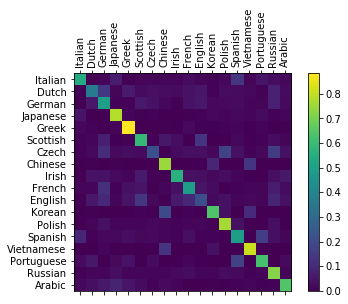

In [21]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

### Running on User Input

In [22]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.28) Russian
(-1.72) Czech
(-3.35) Polish

> Jackson
(-0.84) Russian
(-1.37) English
(-2.43) Scottish

> Satoshi
(-0.83) Japanese
(-1.20) Arabic
(-2.26) Italian


## Exercises